In [2]:
from __future__ import annotations
import sys
import os
import re
from collections import Counter
from pathlib import Path
import dotenv
import pandas as pd
import pyopenms
from matplotlib import pyplot as plt
import seaborn as sns
import pyopenms

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
REPO_DIR = Path(os.getcwd()).parent.parent.parent
dotenv.load_dotenv(REPO_DIR/'.env')
DATA_DIR = Path(os.environ.get('DATA_DIR'))

In [5]:
database_path = DATA_DIR/'data/van_puyvelde-2022/Protein/DIA/Database/merged_database-ecoli_yeast_human-20260109.fasta'
acc_2_tier = {}
tier_map = {
    'PE=1': 'Ecoli',
    'PE=2': 'Yeast',
    'PE=3': 'Human'
}
with open(database_path, 'rt') as fh:
    pattern = re.compile(r'PE=\d+')
    for line in fh:
        if not line.startswith('>'):
            continue
        if line.startswith('contam_'):
            continue
        acc = line.split(' ', 1)[0]
        acc = acc.lstrip('>')
        m = pattern.search(line)
        pe = m.group(0) if m else None
        if not pe:
            contiinue
        tier = tier_map[pe]
        acc_2_tier[acc] = tier

In [101]:
class FragPipeResults:
    def __init__(self, base_dir:Path):
        self.base_dir = base_dir
        self._psm = None
        self._peptide = None
        self._protein = None
        self._diann_report = None
        self._peptide_ids = None
        self._protein_ids = None

    @property
    def psm(self):
        if self._psm is None:
            self._psm = pd.read_csv(self.base_dir/'psm.tsv', delimiter='\t')
        return self._psm

    @property
    def peptide(self):
        if self._peptide is None:
            self._peptide = pd.read_csv(self.base_dir/'peptide.tsv', delimiter='\t')
        return self._peptide

    @property
    def protein(self):
        if self._protein is None:
            self._protein = pd.read_csv(self.base_dir/'protein.tsv', delimiter='\t')
        return self._protein

    @property
    def diann_report(self):
        if self._protein is None:
            self._protein = pd.read_csv(self.base_dir/'dia-quant-output/report.tsv', delimiter='\t')
        return self._protein

    @property
    def protein_ids(self):
        if self._protein_ids is None:
            self._load_idxml()
        return self._protein_ids

    @property
    def peptide_ids(self):
        if self._peptide_ids is None:
            self._load_idxml()
        return self._peptide_ids

    def _load_idxml(self):
        protein_ids = []
        peptide_ids = pyopenms.PeptideIdentificationList()
        path = list(self.base_dir.glob('*.idXML'))
        if not path:
            raise FileNotFoundError(f'IdXML cannot be found: {self.base_dir}')
        path = str(path[0])
        pyopenms.IdXMLFile().load(path, protein_ids, peptide_ids)
        self._protein_ids = protein_ids
        self._peptide_ids = peptide_ids

def tidy_peptide_id(peptide_ids):
    data = {
        'Spectrum Reference': [],
        'RT': [],
        'Observed M/Z': [],
        'Tier': [],
        'Peptide': [],
        'Charge': [],
        'Qvalue': [],
        'Probability': [],
        'Hyperscore': [],
        'Nextscore': []
    }
    label_map = {
        -1: "Contam",
         1: "Ecoli",
         2: "Yeast",
         3: "Human",
    }
    for pep_id in peptide_ids:
        hits = pep_id.getHits()
        if not len(hits) > 0:
            continue
        hit = hits[0]
        data['Spectrum Reference'].append(pep_id.getMetaValue('spectrum_reference'))
        data['RT'].append(pep_id.getRT())
        data['Observed M/Z'].append(pep_id.getMZ())
        if hit.metaValueExists('tier'):
            tier = label_map[hit.getMetaValue('tier')]
        else:
            tier = None
        data['Tier'].append(tier)
        data['Peptide'].append(hit.getSequence().toUnmodifiedString())
        data['Charge'].append(hit.getCharge())
        data['Qvalue'].append(hit.getScore())
        data['Probability'].append(hit.getMetaValue('PeptideProphet probability_score'))
        data['Hyperscore'].append(hit.getMetaValue('hyperscore'))
        data['Nextscore'].append(hit.getMetaValue('nextscore'))
    return pd.DataFrame(data)

def tidy_protein_groups(prot_id, acc_2_tier):
    df = {
        'Protein Group': [],
        'Probability': [],
        'Qvalue': [],
        'Tier': []
    }
    for x, y in zip(prot_id.getProteinGroups(), prot_id.getIndistinguishableProteins()):
        acc = x.accessions[0].decode('utf-8')
        df['Protein Group'].append(acc)
        df['Probability'].append(x.probability)
        df['Qvalue'].append(y.probability)
        if acc.startswith('contam_') or acc.startswith('rev_contam_'):
            tier = 'Contam'
        else:
            if acc.startswith('rev_'):
                acc = acc[4:]
            tier = acc_2_tier[acc]
        df['Tier'].append(tier)
    df = pd.DataFrame(df)
    return(df)

In [74]:
fragpipe_dir = DATA_DIR/'data/van_puyvelde-2022/Protein/DIA/fragpipe/v02'
fragpipe_results = {
    'ecoli_01': FragPipeResults(fragpipe_dir/'LFQ_TTOF5600_SWATH_Ecoli_01'),
    'yeast_01': FragPipeResults(fragpipe_dir/'LFQ_TTOF5600_SWATH_Yeast_01'),
    'human_01': FragPipeResults(fragpipe_dir/'LFQ_TTOF5600_SWATH_Human_01'),
    'condition_a_alpha_01': FragPipeResults(fragpipe_dir/'LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01/'),
    'condition_b_alpha_01': FragPipeResults(fragpipe_dir/'LFQ_TTOF5600_SWATH_Condition_B_Sample_Alpha_01')   
}

In [69]:
Counter(x in acc_2_tier for x in fragpipe_results['condition_a_alpha_01'].psm['Protein'])

Counter({True: 25685})

In [81]:
def func(data):
    cols = ["Qvalue", "Probability", "Hyperscore", "Protein"]
    df= data.psm[cols] .assign(Tier=lambda x: x["Protein"].map(acc_2_tier))
    df['rank_global'] = df["Qvalue"].rank(method="first", ascending=True).astype(int)
    df['rank_tier'] = df.groupby("Tier")["Qvalue"].rank(method="first", ascending=True).astype(int)
    return(df)

<Axes: xlabel='Qvalue', ylabel='Probability'>

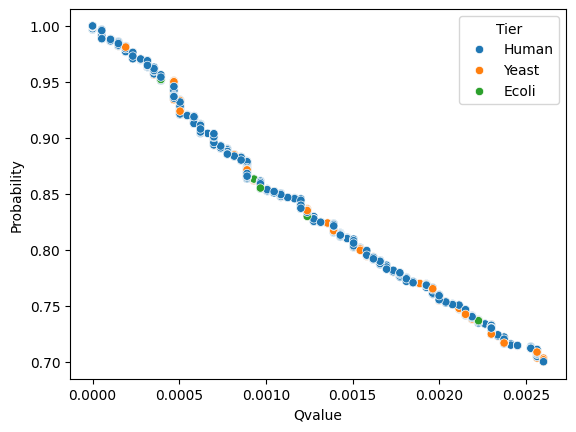

In [82]:
df = func(fragpipe_results['condition_a_alpha_01'])
sns.scatterplot(
    data=df,
    x='Qvalue',
    y='Probability',
    hue='Tier'
)

<Axes: xlabel='rank_global', ylabel='Qvalue'>

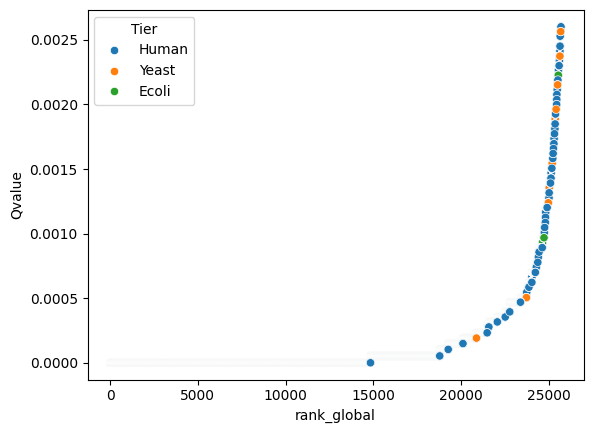

In [89]:
sns.scatterplot(
    data=df,
    x='rank_global',
    y='Qvalue',
    hue='Tier'
)

In [79]:
df[df["Qvalue"] <= 0.01].groupby("Tier")["Probability"].min()

Tier
Ecoli    0.7130
Human    0.7003
Yeast    0.7001
Name: Probability, dtype: float64

<Axes: xlabel='rank', ylabel='q-value'>

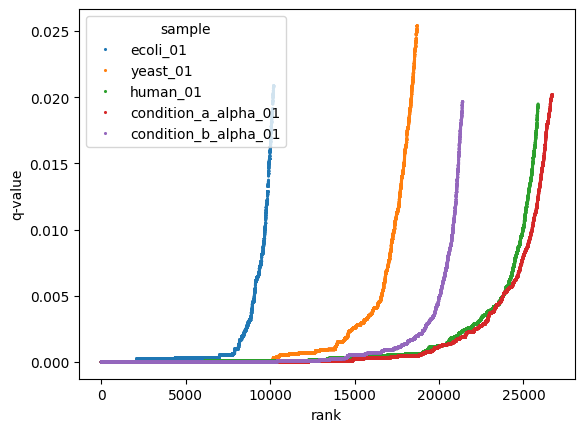

In [10]:
def func(data, sample):    
    df = pd.DataFrame({
        'q-value': sorted(p.getHits()[0].getScore() for p in data.peptide_ids if len(p.getHits()) > 0)
    })
    df['rank'] = df.index + 1
    df['sample'] = sample
    return df
df = pd.concat(
    [func(v, k) for k,v in fragpipe_results.items()],
    axis=0,
    ignore_index=True
)
sns.scatterplot(
    data=df,
    x="rank",
    y="q-value",
    hue='sample',
    s=5,
    linewidth=0
)

In [57]:
fragpipe_results['condition_a_alpha_01'].peptide_ids[0].getHits()[0].getMetaValue('PeptideProphet probability_score')

0.99751

In [60]:
def func(data, sample):
    df = {
        'qval': [],
        'tier': [],
        'prob': [],
        'hyperscore': []
    }
    for p in data.peptide_ids:
        if p.getHits() == 0:
            continue
        hit = p.getHits()[0]
        q_value = hit.getScore()
        prob = hit.getMetaValue('PeptideProphet probability_score')
        hyperscore = hit.getMetaValue('hyperscore')
        acc = hit.getPeptideEvidences()[0].getProteinAccession()
        if acc not in acc_2_tier:
            continue
        tier = acc_2_tier[acc]
        df['qval'].append(q_value)
        df['prob'].append(prob)
        df['hyperscore'].append(hyperscore)
        df['tier'].append(tier)
    df = pd.DataFrame(df)
    df = df.sort_values(['tier', 'qval']).reset_index(drop=True)
    df['rank'] = df.groupby('tier')['qval'].cumcount() + 1
    return(df)

<Axes: xlabel='qval', ylabel='prob'>

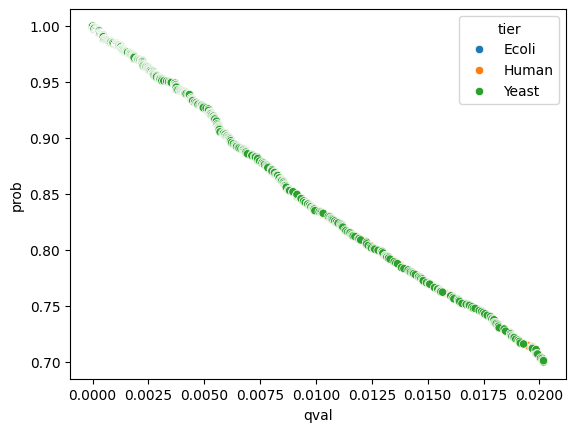

In [61]:
df = func(fragpipe_results['condition_a_alpha_01'], 'condition_a_alpha_01')
sns.scatterplot(
    data=df,
    x='qval',
    y='prob',
    hue='tier'
)

Text(0.5, 1.0, 'FragPipe Group FDR')

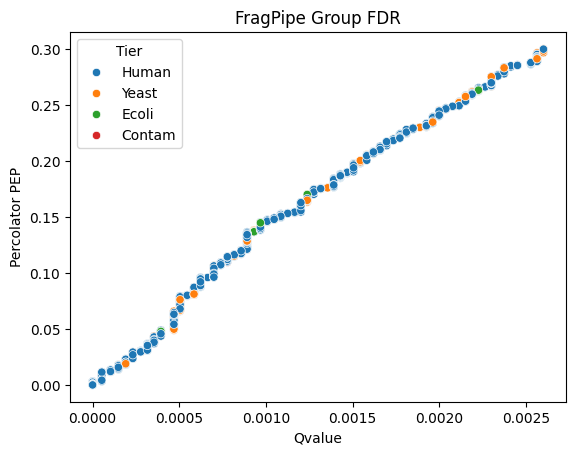

In [96]:
sns.scatterplot(
    data=df_merge,
    x='Qvalue_x',
    y=1-df_merge['Probability_x'],
    hue='Tier'
)
plt.xlabel('Qvalue'),
plt.ylabel('Percolator PEP')
plt.title('FragPipe Group FDR')

In [9]:
pep_id = pyopenms.PeptideIdentification()
prot_id = pyopenms.ProteinIdentification()
file = str(fragpipe_dir/'LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01/combined_fixed.prot.xml')
pyopenms.ProtXMLFile().load(file, prot_id, pep_id)

Required attribute 'percent_coverage' missing


Non-fatal error while loading '/mnt/s3bucket/data/van_puyvelde-2022/Protein/DIA/fragpipe/v02/LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01/combined_fixed.prot.xml': Modification '160.030650000000009' is not uniquely defined by the given data. Using 'Carbamidomethyl (N-term)' to represent any of 'Carbamidomethyl (N-term), Carbamidomethyl (C)'!
Non-fatal error while loading '/mnt/s3bucket/data/van_puyvelde-2022/Protein/DIA/fragpipe/v02/LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01/combined_fixed.prot.xml': Modification '147.03540000000001' is not uniquely defined by the given data. Using 'Oxidation (M)' to represent any of 'Oxidation (M), oxidation to L-methionine sulfoxide (M), oxidation to L-methionine (R)-sulfoxide (M), oxidation to L-methionine (S)-sulfoxide (M)'!


<Axes: ylabel='Count'>

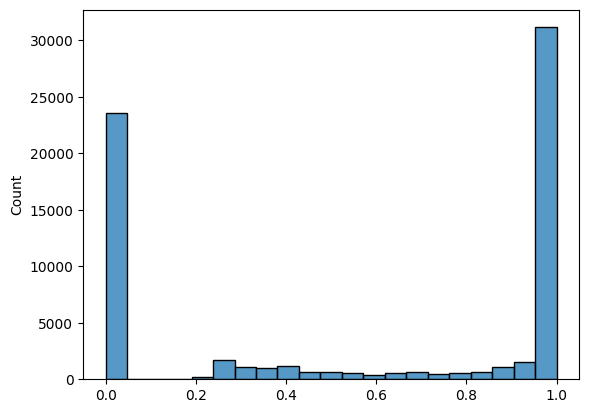

In [26]:
sns.histplot(
    x=[x.getScore() for x in prot_id.getHits()]
)

In [49]:
prot_id.isHigherScoreBetter()

True

In [45]:
pg = prot_id.getProteinGroups()[0]
pg.probability

1.0

<Axes: ylabel='Count'>

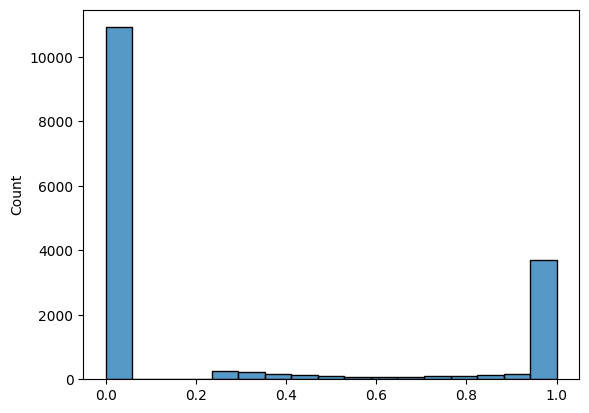

In [48]:
sns.histplot(
    x = [x.probability for x in prot_id.getProteinGroups()]
)

In [50]:
[x for x in prot_id.getProteinGroups() if 'AAC76364' in x.accessions]

[]

In [54]:
prot_id.getProteinGroups()[53].accessions

[b'ENSP00000000233.5', b'ENSP00000534510.1', b'ENSP00000604526.1']

In [14]:
set(acc_2_tier.values())

{'Ecoli', 'Human', 'Yeast'}

In [46]:
fdr = pyopenms.FalseDiscoveryRate()
params = fdr.getParameters()

In [47]:
pg = pyopenms.ProteinGroup()
pg.

In [19]:
df_pg = {
    'Protein Group Leader': [], 
    'Probability': [], 
    'Number of Indistinguishable Proteins': [], 
    'Indistinguishable Protein': [],
    'Target/Decoy': [], 
    'Database Tier': []
}
for pg in prot_id.getProteinGroups():
    leader = pg.accessions[0].decode('utf-8')
    for acc in pg.accessions:
        acc = acc.decode('utf-8')
        if acc.startswith('rev_'):
            target_decoy = 'decoy'
            acc = acc[4:]
        else:
            target_decoy = 'target'
        if acc.startswith('contam_'):
            tier = 'Contam'
        else:
            tier = acc_2_tier[acc]
        df_pg['Protein Group Leader'].append(leader)
        df_pg['Probability'].append(pg.probability)
        df_pg['Number of Indistinguishable Proteins'].append(len(pg.accessions))
        df_pg['Indistinguishable Protein'].append(acc)
        df_pg['Target/Decoy'].append(target_decoy)
        df_pg['Database Tier'].append(tier)
df_pg = pd.DataFrame(df_pg)

In [20]:
df_pg

,Protein Group Leader,Probability,Number of Indistinguishable Proteins,Indistinguishable Protein,Target/Decoy,Database Tier
0,AAC73119,1.0,1,AAC73119,target,Ecoli
1,AAC73125,1.0,1,AAC73125,target,Ecoli
2,AAC73229,1.0,1,AAC73229,target,Ecoli
3,AAC73281,1.0,1,AAC73281,target,Ecoli
4,AAC73706,1.0,1,AAC73706,target,Ecoli
...,...,...,...,...,...,...
67714,rev_ENSP00000551794.1,0.0,2,ENSP00000551794.1,decoy,Human
67715,rev_ENSP00000551794.1,0.0,2,ENSP00000551797.1,decoy,Human
67716,rev_ONH74442,0.0,1,ONH74442,decoy,Yeast
67717,rev_ONH79625,0.0,1,ONH79625,decoy,Yeast


In [41]:
df_pg["n_database_tiers"] = df_pg.groupby("Protein Group Leader")["Database Tier"].transform("nunique")
df_pg["n_database_tiers_no_contam"] = df_pg.groupby("Protein Group Leader")["Database Tier"].transform(lambda x: x[x != 'Contam'].nunique())
df_pg[df_pg['n_database_tiers_no_contam'] > 1]['Protein Group Leader'].unique()

array(['ENSP00000216442.7', 'ENSP00000392848.2', 'ENSP00000281543.5',
       'ENSP00000232461.3', 'ONH80646', 'AAC73511', 'AAC74383',
       'AAC75517', 'ENSP00000181839.4', 'ENSP00000222120.2',
       'ENSP00000245121.4', 'ENSP00000295701.5', 'ENSP00000386764.1',
       'ENSP00000397045.1', 'ENSP00000411749.1', 'ENSP00000422404.1',
       'ENSP00000450162.1', 'ENSP00000462001.1', 'ENSP00000489811.2',
       'ENSP00000522222.1', 'ONH72740'], dtype=object)

In [79]:
split_fdr = ([], pyopenms.PeptideIdentificationList())
file = str(fragpipe_dir/'LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01/LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01.idXML')
pyopenms.IdXMLFile().load(file, split_fdr[0], split_fdr[1])
global_fdr = ([], pyopenms.PeptideIdentificationList())
file = str(fragpipe_dir/'LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01/LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01_global_fdr.idXML')
pyopenms.IdXMLFile().load(file, global_fdr[0], global_fdr[1])

<Axes: ylabel='Count'>

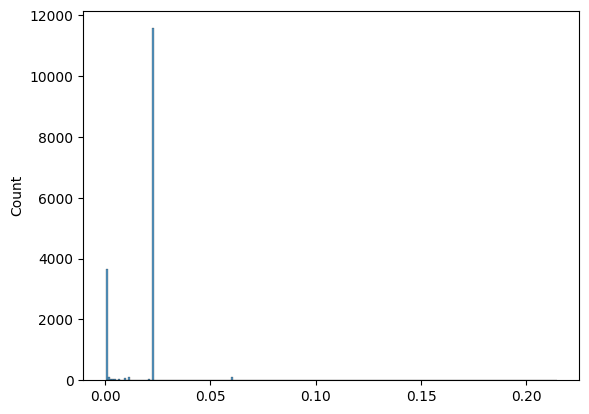

In [80]:
sns.histplot(
    x = [x.probability for x in split_fdr[0][0].getIndistinguishableProteins()]
)

<Axes: ylabel='Count'>

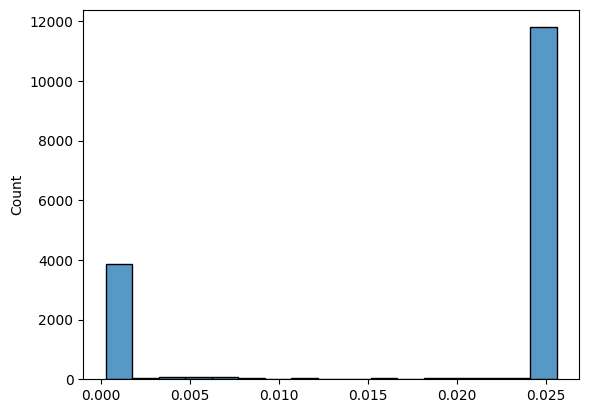

In [81]:
sns.histplot(
    x = [x.probability for x in global_fdr[0][0].getIndistinguishableProteins()]
)

<Axes: xlabel='Qvalue', ylabel='Probability'>

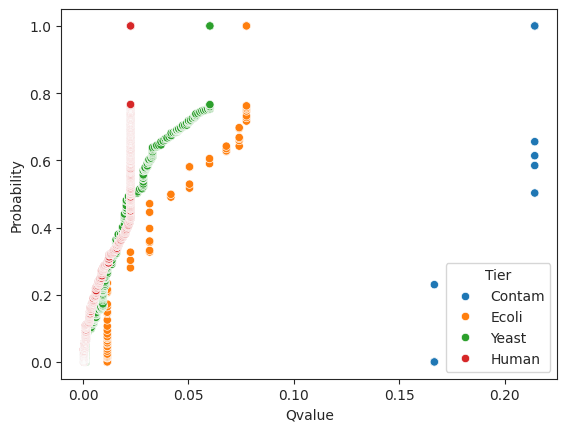

In [133]:
df = tidy_protein_groups(split_fdr[0][0], acc_2_tier)
sns.scatterplot(
    data=df,
    x='Qvalue',
    y=1-df['Probability'],
    hue='Tier'
)

<Axes: xlabel='Qvalue', ylabel='Probability'>

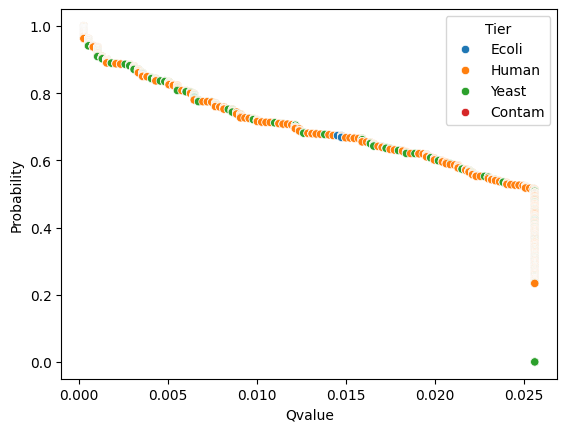

In [91]:
df = tidy_protein_groups(global_fdr[0][0], acc_2_tier)
df = pd.DataFrame(df)
sns.scatterplot(
    data=df,
    x='Qvalue',
    y='Probability',
    hue='Tier'
)

In [76]:
tiers = []
df_protein = fragpipe_results['condition_a_alpha_01'].protein
for protein in df_protein['Protein']:
    if protein.startswith('contam_') or protein.startswith('rev_contam_'):
        tiers.append('Contam')
    else:
        if protein.startswith('rev_'):
            protein = protein[4:]
        tiers.append(acc_2_tier[protein])
df_protein['Tier'] = tiers

<Axes: xlabel='Protein Qvalue', ylabel='Protein Probability'>

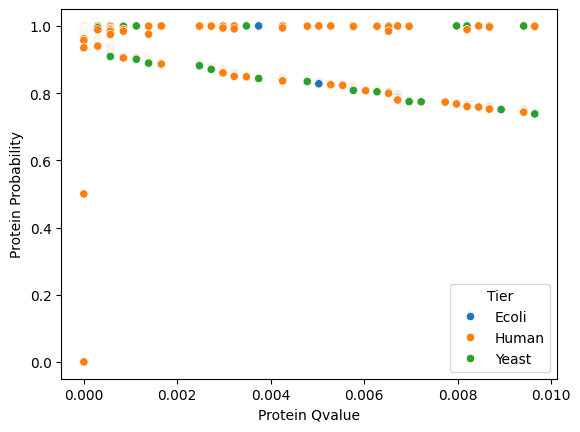

In [78]:
sns.scatterplot(
    data=df_protein,
    x='Protein Qvalue',
    y='Protein Probability',
    hue='Tier'
)

In [109]:
df_peptide_split_fdr = tidy_peptide_id(split_fdr[1])
df_peptide_global_fdr = tidy_peptide_id(global_fdr[1])
df_merge = fragpipe_results['condition_a_alpha_01'].psm[['Spectrum', 'Retention', 'Observed M/Z', 'Peptide', 'Charge', 'Qvalue', 'Probability', 'Hyperscore', 'Expectation']]
df_merge = df_merge.merge(
    df_peptide_split_fdr,
    left_on=["Retention", "Peptide", "Charge"],
    right_on=["RT", "Peptide", "Charge"],
    suffixes = ('_fragpipe', '_split_fdr'),
    how='inner'
).rename(
    columns={x: f'{x}_fragpipe' for x in ['Expectation']}
).rename(
    columns={x: f'{x}_fragpipe' for x in ['Nextscore']}
).merge(
    df_peptide_global_fdr.drop(columns=['RT', 'Peptide', 'Charge', 'Observed M/Z', 'Tier']),
    on=['Spectrum Reference'],
    how='inner'
).rename(
    columns={
        c:f"{c}_global_fdr" for c in ["Qvalue", "Probability", "Hyperscore", 'Nextscore']
    }
)

In [141]:
df_merge

,Spectrum,Retention,Observed M/Z_fragpipe,Peptide,Charge,Qvalue_fragpipe,Probability_fragpipe,Hyperscore_fragpipe,Expectation_fragpipe,Spectrum Reference,RT,Observed M/Z_split_fdr,Tier,Qvalue_split_fdr,Probability_split_fdr,Hyperscore_split_fdr,Nextscore_fragpipe,Qvalue_global_fdr,Probability_global_fdr,Hyperscore_global_fdr,Nextscore_global_fdr
0,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,198.574,440.8580,HSDENDGGQPHK,3,0.000000,0.9975,19.5035,1.106982e-02,sample=1 period=1 cycle=57 experiment=7,198.574,440.857825,Human,0.000086,0.997510,19.503532,19.503532,0.000067,0.997510,19.503532,19.503532
1,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,199.406,550.4785,HDSNASPNSDSEDGHHHNNK,4,0.000000,0.9995,16.0113,3.637475e-01,sample=1 period=1 cycle=57 experiment=23,199.406,550.477575,Yeast,0.000000,0.999537,16.011295,10.397560,0.000000,0.999537,16.011295,10.397560
2,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,200.184,660.7848,HSDENDGGQPHK,2,0.000000,0.9971,25.0194,4.452742e-05,sample=1 period=1 cycle=57 experiment=38,200.184,660.784125,Human,0.000086,0.997116,25.019405,25.019405,0.000067,0.997116,25.019405,25.019405
3,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,200.807,778.8762,EQQQQQQQQQQK,2,0.000053,0.9954,21.1714,2.088402e-03,sample=1 period=1 cycle=57 experiment=50,200.807,778.876175,Human,0.000372,0.995421,21.171356,11.162375,0.000292,0.995421,21.171356,11.162375
4,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,202.372,474.2130,RPDSSDDR,2,0.000469,0.9374,17.0683,1.264031e-01,sample=1 period=1 cycle=58 experiment=12,202.372,474.212625,Human,0.004163,0.937379,17.068280,11.461714,0.004335,0.937379,17.068280,11.461714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31136,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,5440.287,1192.5609,ANPDPNCCLGVFGLSLYTTER,2,0.000000,1.0000,51.4556,0.000000e+00,sample=1 period=1 cycle=1538 experiment=65,5440.287,1192.552975,Human,0.000000,0.999956,51.455630,36.046560,0.005937,0.903806,46.028347,36.046560
31137,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,5440.287,1150.5270,SAAEMYGSVTEHPSPSPLLSSSFDLDYDFQR,3,0.000700,0.9038,46.0283,3.000000e-14,sample=1 period=1 cycle=1538 experiment=65,5440.287,1150.519858,Human,0.005934,0.903806,46.028347,36.046560,0.000000,0.999883,53.311080,36.046560
31138,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,5440.287,1150.5270,SAAEMYGSVTEHPSPSPLLSSSFDLDYDFQR,3,0.000700,0.9038,46.0283,3.000000e-14,sample=1 period=1 cycle=1538 experiment=65,5440.287,1150.519858,Human,0.005934,0.903806,46.028347,36.046560,0.000000,0.999956,51.455630,36.046560
31139,LFQ_TTOF5600_SWATH_Condition_A_Sample_Alpha_01...,5440.287,1150.5270,SAAEMYGSVTEHPSPSPLLSSSFDLDYDFQR,3,0.000700,0.9038,46.0283,3.000000e-14,sample=1 period=1 cycle=1538 experiment=65,5440.287,1150.519858,Human,0.005934,0.903806,46.028347,36.046560,0.005937,0.903806,46.028347,36.046560


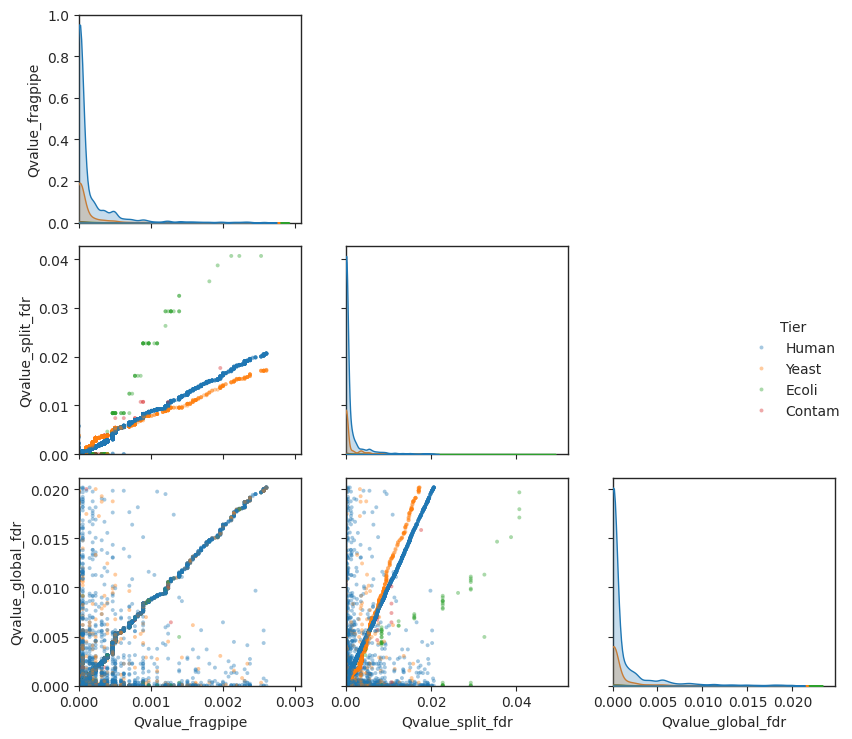

In [131]:
sns.set_style(
    "ticks", 
    rc={
        "axes.spines.top": True,
        "axes.spines.right": True,
        "axes.linewidth": 1,
    }
)
g = sns.pairplot(
    df_merge,
    vars=[
        "Qvalue_fragpipe",
        "Qvalue_split_fdr",
        "Qvalue_global_fdr",
    ],
    hue="Tier",
    corner=True,
    plot_kws=dict(
        s=8,
        alpha=0.4,
        linewidth=0
    )
)
n = len(g.x_vars)

for i in range(n):
    for j in range(n):
        ax = g.axes[i, j]
        if ax is None:
            continue

        # ---- spines ----
        for side in ["left", "right", "top", "bottom"]:
            ax.spines[side].set_visible(True)
            ax.spines[side].set_linewidth(1)

        # ---- base tick policy: left + bottom only ----
        ax.tick_params(
            axis="x",
            which="both",
            bottom=True,
            top=False
        )
        ax.tick_params(
            axis="y",
            which="both",
            left=True,
            right=False
        )

        # ---- column rule: cols 2 & 3 (j = 1, 2) → no y labels ----
        if j in (1, 2):
            ax.tick_params(axis="y", labelleft=False)
        else:
            ax.tick_params(axis="y", labelleft=True)

        # ---- row rule: rows 1 & 2 (i = 0, 1) → no x labels ----
        if i in (0, 1):
            ax.tick_params(axis="x", labelbottom=False)
        else:
            ax.tick_params(axis="x", labelbottom=True)

# ---- restore diagonal y-axes explicitly (PairGrid quirk) ----
for i in range(n):
    ax = g.axes[i, i]
    if ax is not None:
        ax.yaxis.set_visible(True)

# ---- optional: remove y-axis LABEL TEXT on diagonal except top-left ----
for i in [1, 2]:
    ax = g.axes[i, i]
    if ax is not None:
        ax.set_ylabel("")
for ax in g.axes.flat:
    if ax is None:
        continue
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
g.fig.tight_layout()

Text(0.5, 1.0, 'Split FDR')

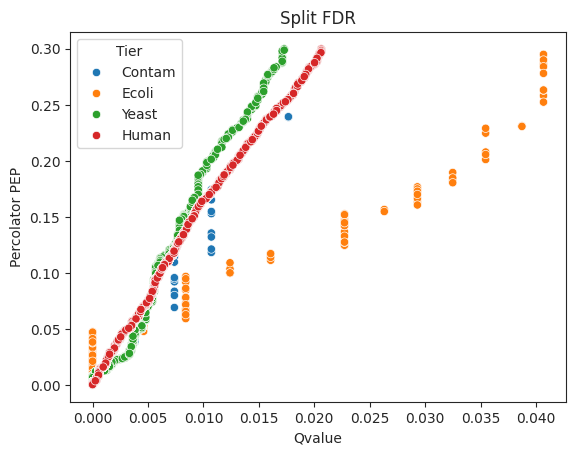

In [139]:
df = tidy_peptide_id(split_fdr[1])
sns.scatterplot(
    data=df,
    x='Qvalue',
    y=1-df['Probability'],
    hue='Tier'
)
plt.xlabel('Qvalue'),
plt.ylabel('Percolator PEP')
plt.title('Split FDR')

Text(0.5, 1.0, 'FragPipe')

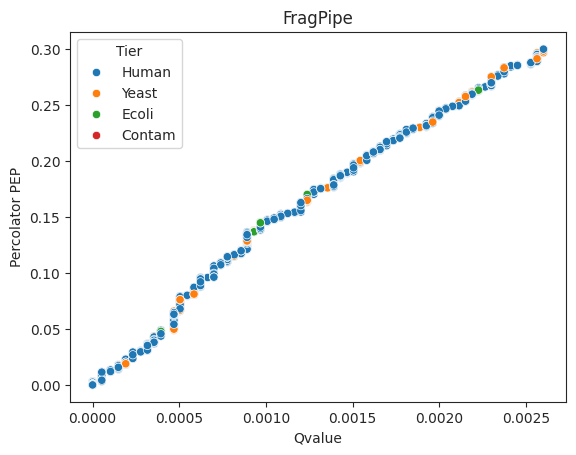

In [142]:
sns.scatterplot(
    data=df_merge,
    x='Qvalue_fragpipe',
    y=1-df_merge['Probability_fragpipe'],
    hue='Tier'
)
plt.xlabel('Qvalue'),
plt.ylabel('Percolator PEP')
plt.title('FragPipe')